In [1]:
'''

update history:

1、


=================================================
goals:

ENSO位相转换 case挑选合成分析

'''
from mailbox import _PartialFile
import numpy as np
import xarray as xr
import os
import re
from cdo import Cdo
import shutil
import sys

sys.path.append("/home/ys17-23/chenhj/self_def/")
import plot as sepl
import cal as ca
import pandas as pd
from importlib import reload

import metpy.calc as mpcalc
import metpy.constants as constants
import geocat.comp
from windspharm.xarray import VectorWind
import skill_metrics as sm
from brokenaxes import brokenaxes

reload(sepl)

# sd.path.append("/home/ys17-23/chenhj/1201code/self_def.py")

cdo = Cdo()

# for plot
import proplot as pplt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter
from cartopy.mpl.ticker import LatitudeFormatter
from cartopy.util import add_cyclic_point
from matplotlib.ticker import MultipleLocator
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import t
from scipy import signal
from eofs.multivariate.standard import MultivariateEof
from eofs.standard import Eof
import statsmodels.api as sm

# 读取数据

In [2]:
fpreGPCP = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/GPCP_r144x72_197901-201412.nc"
)
preGPCP = fpreGPCP["precip"]
preGPCP_JJA = ca.p_time(preGPCP, 6, 8, True)
preGPCP_JJA = ca.detrend_dim(preGPCP_JJA, "time", deg=1, demean=False)

fhgtERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/hgt_mon_r144x72_195001-201412.nc")
hgtERA5 = fhgtERA5["z"].sel(time=fhgtERA5["time"].dt.year>=1979)

fuERA5 = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/uwind_mon_r144x72_195001-201412.nc"
)
uERA5 = fuERA5["u"].sel(time=fuERA5["time"].dt.year>=1979)

fvERA5 = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/vwind_mon_r144x72_195001-201412.nc"
)
vERA5 = fvERA5["v"].sel(time=fvERA5["time"].dt.year>=1979)

fspERA5 = xr.open_dataset(
    "/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/sp_mon_r144x72_195001-201412.nc"
)
spERA5 = fspERA5["sp"].sel(time=fspERA5["time"].dt.year>=1979)

fqERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/q_mon_r144x72_195001-201412.nc")
qERA5 = fqERA5["q"].sel(time=fqERA5["time"].dt.year>=1979)

fwERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/omega_mon_r144x72_195001-201412.nc")
wERA5 = fwERA5["w"].sel(time=fwERA5["time"].dt.year>=1979)

fsstHad = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/HadISST_r144x72_1870-2020.nc")
sstHad = fsstHad["sst"].sel(time=(fsstHad["time"].dt.year>=1979) & (fsstHad["time"].dt.year<=2014))

hgtERA5_ver_JJA = ca.p_time(hgtERA5, 6, 8, True)
# hgtERA5_ver_JJA = hgtERA5_ver_JJA-hgtERA5_ver_JJA.mean(dim="lon", skipna=True)
hgtERA5_ver_JJA = ca.detrend_dim(hgtERA5_ver_JJA, "time", deg=1, demean=False)

uERA5_ver_MAM, uERA5_ver_JJA, uERA5_ver_SON, uERA5_ver_DJF = ca.mon_to_season(uERA5)
# uERA5_ver_JJA_cli = uERA5_ver_JJA.copy()
uERA5_ver_MAM = ca.detrend_dim(uERA5_ver_MAM, "time", deg=1, demean=False)
uERA5_ver_JJA = ca.detrend_dim(uERA5_ver_JJA, "time", deg=1, demean=False)
uERA5_ver_SON = ca.detrend_dim(uERA5_ver_SON, "time", deg=1, demean=False)
uERA5_ver_DJF = ca.detrend_dim(uERA5_ver_DJF, "time", deg=1, demean=False)

vERA5_ver_MAM, vERA5_ver_JJA, vERA5_ver_SON, vERA5_ver_DJF = ca.mon_to_season(vERA5)
vERA5_ver_MAM = ca.detrend_dim(vERA5_ver_MAM, "time", deg=1, demean=False)
vERA5_ver_JJA = ca.detrend_dim(vERA5_ver_JJA, "time", deg=1, demean=False)
vERA5_ver_SON = ca.detrend_dim(vERA5_ver_SON, "time", deg=1, demean=False)
vERA5_ver_DJF = ca.detrend_dim(vERA5_ver_DJF, "time", deg=1, demean=False)

qERA5_ver_JJA = ca.p_time(qERA5, 6, 8, True)
qERA5_ver_JJA = ca.detrend_dim(qERA5_ver_JJA, "time", deg=1, demean=False)

spERA5_MAM, spERA5_JJA, spERA5_SON, spERA5_DJF = ca.mon_to_season(spERA5)
spERA5_MAM = ca.detrend_dim(spERA5_MAM, "time", deg=1, demean=False)
spERA5_JJA = ca.detrend_dim(spERA5_JJA, "time", deg=1, demean=False)
spERA5_SON = ca.detrend_dim(spERA5_SON, "time", deg=1, demean=False)
spERA5_DJF = ca.detrend_dim(spERA5_DJF, "time", deg=1, demean=False)

wERA5_MAM, wERA5_JJA, wERA5_SON, wERA5_DJF = ca.mon_to_season(wERA5)
wERA5_MAM = ca.detrend_dim(wERA5_MAM, "time", deg=1, demean=False)
wERA5_JJA = ca.detrend_dim(wERA5_JJA, "time", deg=1, demean=False)
wERA5_SON = ca.detrend_dim(wERA5_SON, "time", deg=1, demean=False)
wERA5_DJF = ca.detrend_dim(wERA5_DJF, "time", deg=1, demean=False)
sstHad_MAM, sstHad_JJA, sstHad_SON, sstHad_DJF = ca.mon_to_season(sstHad)
sstHad_MAM = ca.detrend_dim(sstHad_MAM, "time", deg=1, demean=False)
sstHad_JJA = ca.detrend_dim(sstHad_JJA, "time", deg=1, demean=False)
sstHad_SON = ca.detrend_dim(sstHad_SON, "time", deg=1, demean=False)
sstHad_DJF = ca.detrend_dim(sstHad_DJF, "time", deg=1, demean=False)
ftERA5 = xr.open_dataset("/home/ys17-23/Extension/personal-data/chenhj/SAM_EAM_data/obs/temp_mon_r144x72_195001-201412.nc")
tERA5 = ftERA5["t"].sel(time=ftERA5["time"].dt.year>=1979)
tERA5_ver_JJA = ca.p_time(tERA5, 6, 8, True)
tERA5_ver_JJA = ca.detrend_dim(tERA5_ver_JJA, "time", deg=1, demean=False)
divERA5_ver_JJA = ca.cal_divergence(uERA5_ver_JJA.sel(level=[200.0, 850.0]), vERA5_ver_JJA.sel(level=[200.0, 850.0]))
divERA5_ver_JJA = ca.detrend_dim(divERA5_ver_JJA, "time", deg=1, demean=False)

#   calculate the waver vapor vertical intergration
ptop = 1
g = 9.8
ERA5level = qERA5_ver_JJA.coords["level"].where(qERA5_ver_JJA.coords["level"] >= ptop) * 100.0
ERA5level.attrs["units"] = "Pa"
ERA5dp = geocat.comp.dpres_plevel(ERA5level, spERA5_JJA, ptop*100)
ERA5dpg = ERA5dp / g
ERA5dpg.attrs["units"] = "kg/m2"
# calculate the water vapor transport
integration_top = 200
uq_sl_ERA5_JJA = uERA5_ver_JJA.loc[:, integration_top:, :, :] * qERA5_ver_JJA.loc[:, integration_top:, :, :].data * 1000.0
vq_sl_ERA5_JJA = vERA5_ver_JJA.loc[:, integration_top:, :, :] * qERA5_ver_JJA.loc[:, integration_top:, :, :].data * 1000.0
uq_sl_ERA5_JJA.attrs["units"] = "[m/s][g/kg]"
vq_sl_ERA5_JJA.attrs["units"] = "[m/s][g/kg]"
# calculate the whole levels water vapor transport
uqERA5_ver_JJA = (uq_sl_ERA5_JJA * ERA5dpg[:, list(ERA5level).index(integration_top*100):, :, :].data).sum(dim="level") / 1e05
vqERA5_ver_JJA = (vq_sl_ERA5_JJA * ERA5dpg[:, list(ERA5level).index(integration_top*100):, :, :].data).sum(dim="level") / 1e05
uqERA5_ver_JJA.attrs["units"] = "100kg m-1 s-1"
vqERA5_ver_JJA.attrs["units"] = "100kg m-1 s-1"
uqERA5_ver_JJA = ca.detrend_dim(uqERA5_ver_JJA, "time", deg=1, demean=False)
vqERA5_ver_JJA = ca.detrend_dim(vqERA5_ver_JJA, "time", deg=1, demean=False)
# calculate the water vapor transportation divergence
uqvqdivERA5_ver_JJA = ca.cal_divergence(uqERA5_ver_JJA, vqERA5_ver_JJA)
uqvqdivERA5_ver_JJA = ca.detrend_dim(uqvqdivERA5_ver_JJA, "time", deg=1, demean=False)

# 计算Nino3.4并去趋势

In [3]:
# 计算Nino 3.4 index并去趋势
Nino34Had = ca.cal_area_weighted_mean(ca.filplonlat(sstHad.copy()).loc[:, -5:5, -170:-120])
Nino34Had = ca.detrend_dim(Nino34Had, "time", deg=1, demean=False)
Nino34Had_MAM, Nino34Had_JJA, Nino34Had_SON, Nino34Had_DJF = ca.mon_to_season(Nino34Had)
Nino34Had_MAM = ca.detrend_dim(Nino34Had_MAM, "time", deg=1, demean=False)
Nino34Had_JJA = ca.detrend_dim(Nino34Had_JJA, "time", deg=1, demean=False)
Nino34Had_SON = ca.detrend_dim(Nino34Had_SON, "time", deg=1, demean=False)
Nino34Had_DJF = ca.detrend_dim(Nino34Had_DJF, "time", deg=1, demean=False)
Nino34Had_MAM_nor = ca.standardize(Nino34Had_MAM)
Nino34Had_JJA_nor = ca.standardize(Nino34Had_JJA)
Nino34Had_SON_nor = ca.standardize(Nino34Had_SON)
Nino34Had_DJF_nor = ca.standardize(Nino34Had_DJF)

{'standard_name': 'sea_surface_temperature', 'long_name': 'sst', 'units': 'C', 'cell_methods': 'time: lat: lon: mean'}


Before flip, lon range is [0.0, 357.5].


After flip, lon range is [-180.0, 177.5].
{'standard_name': 'sea_surface_temperature', 'long_name': 'sst', 'units': 'C', 'cell_methods': 'time: lat: lon: mean'}


# 定义ENSO转换指数

In [4]:
ENSO_shift_index = Nino34Had_JJA[1:]-Nino34Had_DJF.data
ENSO_shift_index_nor = ca.standardize(ENSO_shift_index)

In [36]:
ENSO_shift_index_nor

<xarray.DataArray (time: 35)>
array([-0.14441248,  0.18174284,  0.95500989, -1.69845659,  0.33037116,
        0.58240976,  0.76000717,  0.34082754, -1.78180058,  1.1328038 ,
        0.09546081,  0.23025163, -1.16709704,  0.13509584,  0.24866215,
       -1.00620208,  0.39628696,  1.64294661, -2.59225961,  0.39814864,
        0.81837875,  0.52134986,  0.60175113, -1.02347112, -0.05524148,
       -0.56724574,  0.64351082, -1.07428301,  1.08933407,  1.010452  ,
       -2.36097915,  0.71583851,  0.79795235, -0.3132813 ,  0.15613792])
Coordinates:
  * time     (time) datetime64[ns] 1980-07-01 1981-07-01 ... 2014-07-01
Attributes:
    standard_name:  sea_surface_temperature
    long_name:      sst
    units:          C
    cell_methods:   time: lat: lon: mean

In [35]:
stats.linregress(ENSO_shift_index_nor, Nino34Had_DJF_nor)

LinregressResult(slope=-0.8502013480113135, intercept=-3.2460707140262496e-16, rvalue=-0.8502013480113135, pvalue=1.023821293811224e-10, stderr=0.09164451542381033, intercept_stderr=0.09164451542381033)

# 输出正负异常年年份（1倍标准差）

In [109]:
tmp = Nino34Had_DJF_nor.copy()
tmp.coords["time"] = Nino34Had_JJA_nor[1:].time
pos_year = ENSO_shift_index_nor.time.dt.year.where((tmp>=0.3)&(Nino34Had_JJA_nor[1:]>=0.3), drop=True)
neg_year = ENSO_shift_index_nor.time.dt.year.where(ENSO_shift_index_nor<=-1.0, drop=True)

In [110]:
print(pos_year)
print(neg_year)

<xarray.DataArray 'year' (time: 3)>
array([1987., 1992., 2004.])
Coordinates:
  * time     (time) datetime64[ns] 1987-07-01 1992-07-01 2004-07-01
<xarray.DataArray 'year' (time: 8)>
array([1983., 1988., 1992., 1995., 1998., 2003., 2007., 2010.])
Coordinates:
  * time     (time) datetime64[ns] 1983-07-01 1988-07-01 ... 2010-07-01


# 将正负异常年份挑选

In [111]:
hgt_pos_group = ca.year_choose(pos_year, hgtERA5_ver_JJA)
u_pos_group = ca.year_choose(pos_year, uERA5_ver_JJA)
v_pos_group = ca.year_choose(pos_year, vERA5_ver_JJA)
pre_pos_group = ca.year_choose(pos_year, preGPCP_JJA)
sstDJF_pos_group = ca.year_choose(pos_year, sstHad_DJF)
sstMAM_pos_group = ca.year_choose(pos_year, sstHad_MAM)
sstJJA_pos_group = ca.year_choose(pos_year, sstHad_JJA)
sstSON_pos_group = ca.year_choose(pos_year, sstHad_SON)


hgt_neg_group = ca.year_choose(neg_year, hgtERA5_ver_JJA)
u_neg_group = ca.year_choose(neg_year, uERA5_ver_JJA)
v_neg_group = ca.year_choose(neg_year, vERA5_ver_JJA)
pre_neg_group = ca.year_choose(neg_year, preGPCP_JJA)
sstDJF_neg_group = ca.year_choose(neg_year, sstHad_DJF)
sstMAM_neg_group = ca.year_choose(neg_year, sstHad_MAM)
sstJJA_neg_group = ca.year_choose(neg_year, sstHad_JJA)
sstSON_neg_group = ca.year_choose(neg_year, sstHad_SON)

# 计算正负异常年的组平均

In [112]:
hgt_pos_comp = hgt_pos_group.mean(dim="time")
u_pos_comp = u_pos_group.mean(dim="time")
v_pos_comp = v_pos_group.mean(dim="time")
pre_pos_comp = pre_pos_group.mean(dim="time")
sstDJF_pos_comp = sstDJF_pos_group.mean(dim="time")
sstMAM_pos_comp = sstMAM_pos_group.mean(dim="time")
sstJJA_pos_comp = sstJJA_pos_group.mean(dim="time")
sstSON_pos_comp = sstSON_pos_group.mean(dim="time")

hgt_neg_comp = hgt_neg_group.mean(dim="time")
u_neg_comp = u_neg_group.mean(dim="time")
v_neg_comp = v_neg_group.mean(dim="time")
pre_neg_comp = pre_neg_group.mean(dim="time")
sstDJF_neg_comp = sstDJF_neg_group.mean(dim="time")
sstMAM_neg_comp = sstMAM_neg_group.mean(dim="time")
sstJJA_neg_comp = sstJJA_neg_group.mean(dim="time")
sstSON_neg_comp = sstSON_neg_group.mean(dim="time")

# 计算正、负异常年的显著性检验

In [113]:
hgt_pos_mask = ca.if_two_group_have_diff_mean_t(hgt_pos_group, hgtERA5_ver_JJA)
u_pos_mask = ca.if_two_group_have_diff_mean_t(u_pos_group, uERA5_ver_JJA)
v_pos_mask = ca.if_two_group_have_diff_mean_t(v_pos_group, vERA5_ver_JJA)
pre_pos_mask = ca.if_two_group_have_diff_mean_t(pre_pos_group, preGPCP_JJA)
sstDJF_pos_mask = ca.if_two_group_have_diff_mean_t(sstDJF_pos_group, sstHad_DJF)
sstMAM_pos_mask = ca.if_two_group_have_diff_mean_t(sstMAM_pos_group, sstHad_MAM)
sstJJA_pos_mask = ca.if_two_group_have_diff_mean_t(sstJJA_pos_group, sstHad_JJA)
sstSON_pos_mask = ca.if_two_group_have_diff_mean_t(sstSON_pos_group, sstHad_SON)


hgt_neg_mask = ca.if_two_group_have_diff_mean_t(hgt_neg_group, hgtERA5_ver_JJA)
u_neg_mask = ca.if_two_group_have_diff_mean_t(u_neg_group, uERA5_ver_JJA)
v_neg_mask = ca.if_two_group_have_diff_mean_t(v_neg_group, vERA5_ver_JJA)
pre_neg_mask = ca.if_two_group_have_diff_mean_t(pre_neg_group, preGPCP_JJA)
sstDJF_neg_mask = ca.if_two_group_have_diff_mean_t(sstDJF_neg_group, sstHad_DJF)
sstMAM_neg_mask = ca.if_two_group_have_diff_mean_t(sstMAM_neg_group, sstHad_MAM)
sstJJA_neg_mask = ca.if_two_group_have_diff_mean_t(sstJJA_neg_group, sstHad_JJA)
sstSON_neg_mask = ca.if_two_group_have_diff_mean_t(sstSON_neg_group, sstHad_SON)

In [114]:
wind_pos_mask = ca.wind_check(
    xr.where(u_pos_mask > 0.0, 1.0, 0.0),
    xr.where(v_pos_mask > 0.0, 1.0, 0.0),
    xr.where(u_pos_mask > 0.0, 1.0, 0.0),
    xr.where(v_pos_mask > 0.0, 1.0, 0.0),
)

wind_neg_mask = ca.wind_check(
    xr.where(u_neg_mask > 0.0, 1.0, 0.0),
    xr.where(v_neg_mask > 0.0, 1.0, 0.0),
    xr.where(u_neg_mask > 0.0, 1.0, 0.0),
    xr.where(v_neg_mask > 0.0, 1.0, 0.0),
)

In [115]:
# colormap1 = ["#af6c29",
#              "#c68741",
#              "#dba767",
#              "#f0ce87",
#              "#f2e0a1",
#              "#fdf5bd",
#              "#ffffff",
#              "#ffffff",
#              "#d6fecf",
#              "#aaefb4",
#              "#6abda0",
#              "#7aabc8",
#              "#2671b0",
#              "#103557"]

colormap1 = ["#593205",
             "#714107",
             "#8C510A",
             "#A26519",
             "#BB7D2A",
             "#CA9749",
             "#D8B36B",
             "#E4CB8E",
             "#EEDCAE",
             "#F5E9C9",
             "#ffffff",
             "#ffffff",
             "#DDEFEC",
             "#C8EAE5",
             "#A9DDD5",
             "#89D0C5",
             "#69BDB2",
             "#45A39A",
             "#298C84",
             "#13776F",
             "#006058",
             "#004D43"]
prep_colormap = pplt.Colormap(colormap1)
font_size = 9

# 画图：海温场

/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = li

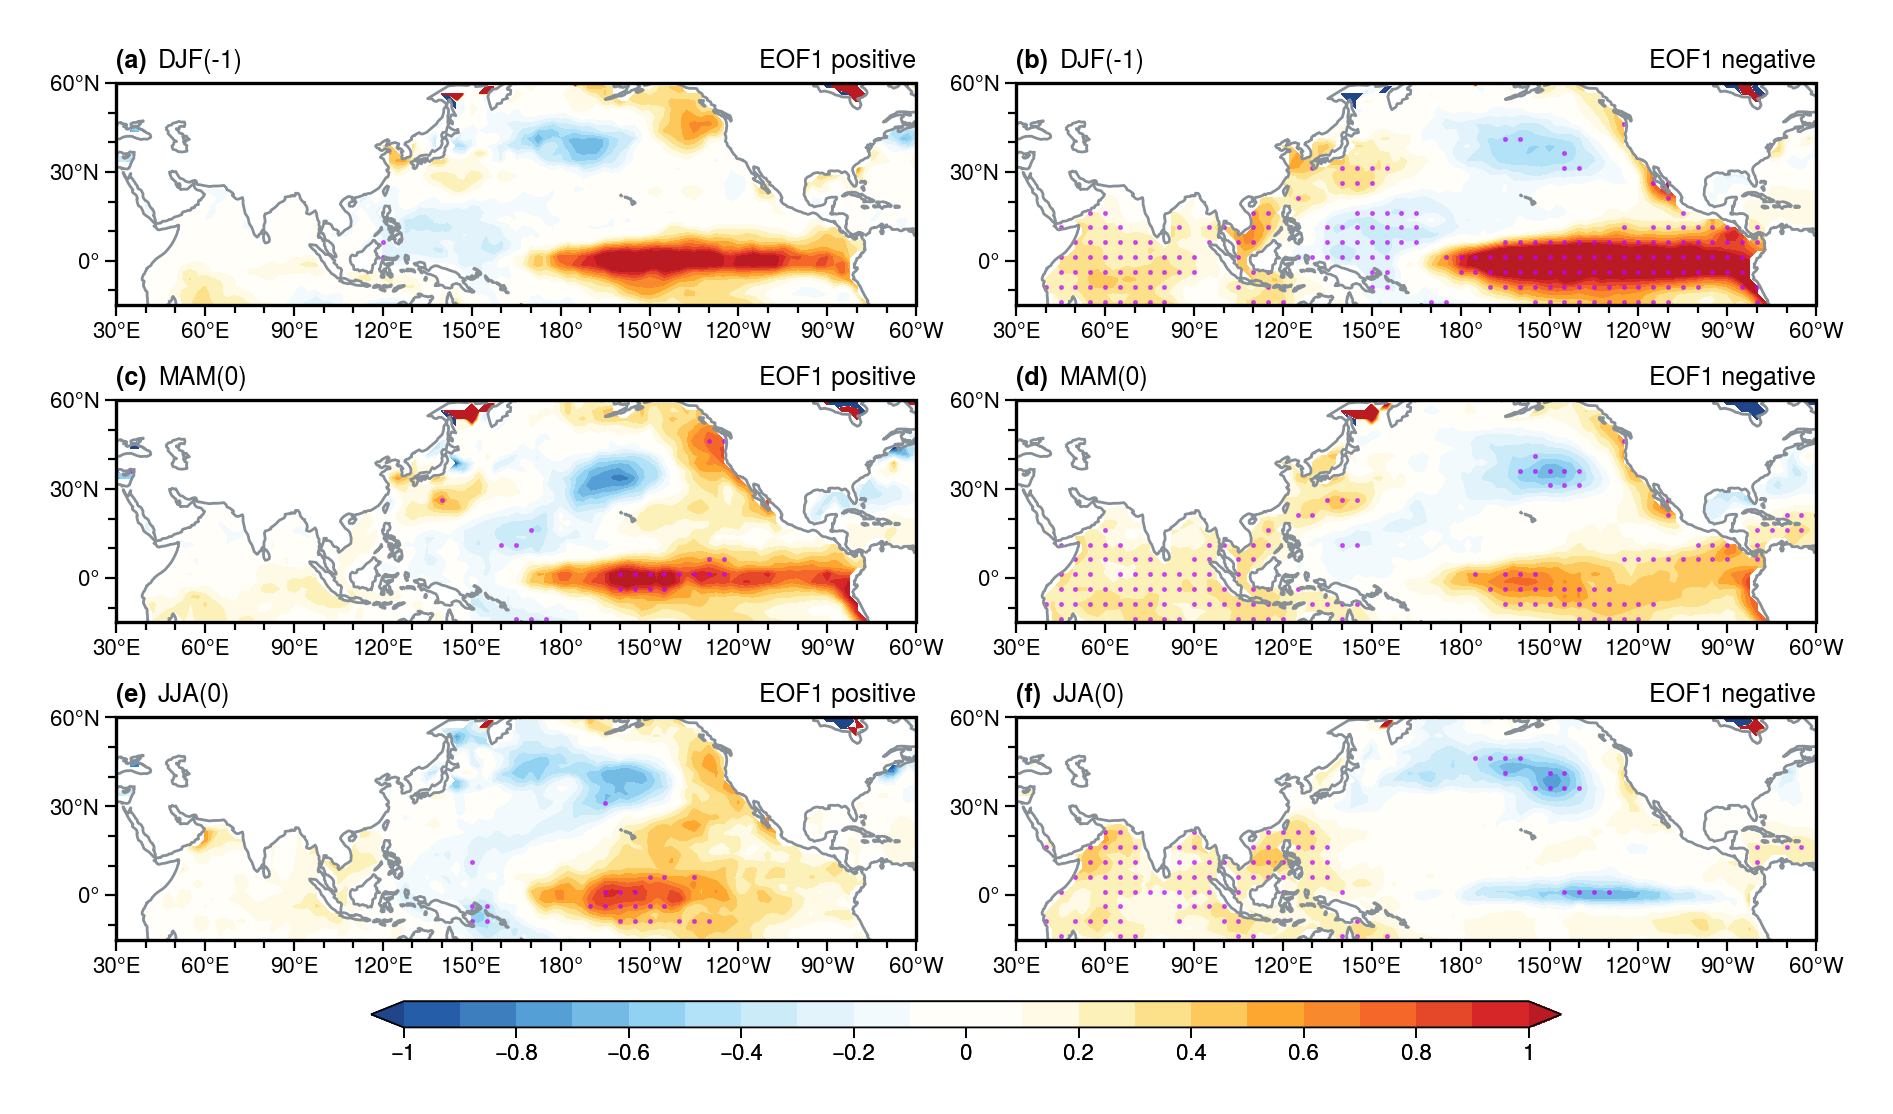

In [116]:
pplt.rc.reset()
pplt.rc.grid = False
startlevel=-1.0
spacinglevel=0.1
cl = 180  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig_GPCP_SST = pplt.figure(span=False, share=False, refwidth=4.0, wspace=4.0, hspace=3.8, outerpad=2.0)
nrows = 3
ncols = 2
plot_array = np.reshape(range(1, nrows*ncols+1), (nrows, ncols))
axs = fig_GPCP_SST.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
# xticks = np.array([30, 60, 90, 120, 150, 180])  # 设置纬度刻度
xticks = np.array([30, 60, 90, 120, 150, 180, 210, 240, 270, 300])  # 设置纬度刻度
yticks = np.arange(0, 61, 30)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [xticks[0], xticks[-1], -15, yticks[-1]]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=8, latminorspace=10, coastlinewidth=1.0)
# ===================================================
ski = 2
n = 2
w, h = 0.12, 0.14
# ======================================
for (i, season), plot_slope, plot_pvalue in zip(enumerate(["DJF(-1)", "MAM(0)", "JJA(0)"]), 
      [sstDJF_pos_comp-sstHad_DJF.mean(dim="time",skipna=True), 
        sstMAM_pos_comp-sstHad_MAM.mean(dim="time",skipna=True), 
        sstJJA_pos_comp-sstHad_JJA.mean(dim="time",skipna=True)], 
      [sstDJF_pos_mask, 
        sstMAM_pos_mask, 
        sstJJA_pos_mask]):
  con = axs[i, 0].contourf(
      plot_slope,
      cmap="ColdHot",
      cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
      levels=np.arange(startlevel, -startlevel+spacinglevel, spacinglevel),
      zorder=0.8,
      extend="both"
  )
  sepl.plt_sig(
      plot_slope, axs[i, 0], n, np.where(plot_pvalue[::n, ::n] > 0), "bright purple", 6.0,
  )

  axs[i, 0].format(
      ltitle="{}".format(season), rtitle="EOF1 positive",
  )
# ======================================
for (i, season), plot_slope, plot_pvalue in zip(enumerate(["DJF(-1)", "MAM(0)", "JJA(0)"]), 
      [sstDJF_neg_comp-sstHad_DJF.mean(dim="time",skipna=True), 
        sstMAM_neg_comp-sstHad_MAM.mean(dim="time",skipna=True), 
        sstJJA_neg_comp-sstHad_JJA.mean(dim="time",skipna=True)], 
      [sstDJF_neg_mask, 
        sstMAM_neg_mask, 
        sstJJA_neg_mask]):
  con = axs[i, 1].contourf(
      plot_slope,
      cmap="ColdHot",
      cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
      levels=np.arange(startlevel, -startlevel+spacinglevel, spacinglevel),
      zorder=0.8,
      extend="both"
  )
  sepl.plt_sig(
      plot_slope, axs[i, 1], n, np.where(plot_pvalue[::n, ::n] > 0), "bright purple", 6.0,
  )

  axs[i, 1].format(
      ltitle="{}".format(season), rtitle="EOF1 negative",
  )
# ======================================
cb = fig_GPCP_SST.colorbar(con, loc="b", width=0.13, length=0.7, label="", ticklabelsize=8.0)
# cb.set_ticks(np.arange(startlevel,-startlevel+0.01,0.24))
# # ======================================
# startlevel=-1.0
# spacinglevel=0.1
# # ======================================
# con = axs[3].contourf(
#     IndR_diff_sst_slope_gens,
#     cmap="ColdHot",
#     cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
#     levels=np.arange(startlevel, -startlevel+spacinglevel, spacinglevel),
#     zorder=0.8,
#     extend="both"
# )
# sepl.plt_sig(
#     IndR_diff_sst_slope_gens, axs[3], n, np.where(IndR_diff_sst_slope_gens_mask[::n, ::n] > 0.00), "bright purple", 3.0,
# )
# axs[3].format(
#     ltitle="diff", rtitle="gMME",
# )
# cb = axs[3].colorbar(con, loc="b", width=0.13, length=0.7, label="", ticklabelsize=8.0)
# cb.set_ticks(np.arange(-1.0,1.1,0.4))
# ======================================
axs.format(linewidth=1.2, titlepad=5.5)
fig_GPCP_SST.format(abc="(a)", abcloc="l", rc_kw={"figure.facecolor":"white", "font.large":9, "legend.fontsize":9, "grid":False, "reso":"lo"})
pplt.rc.reset()

# 画图：环流场合成

/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/hom

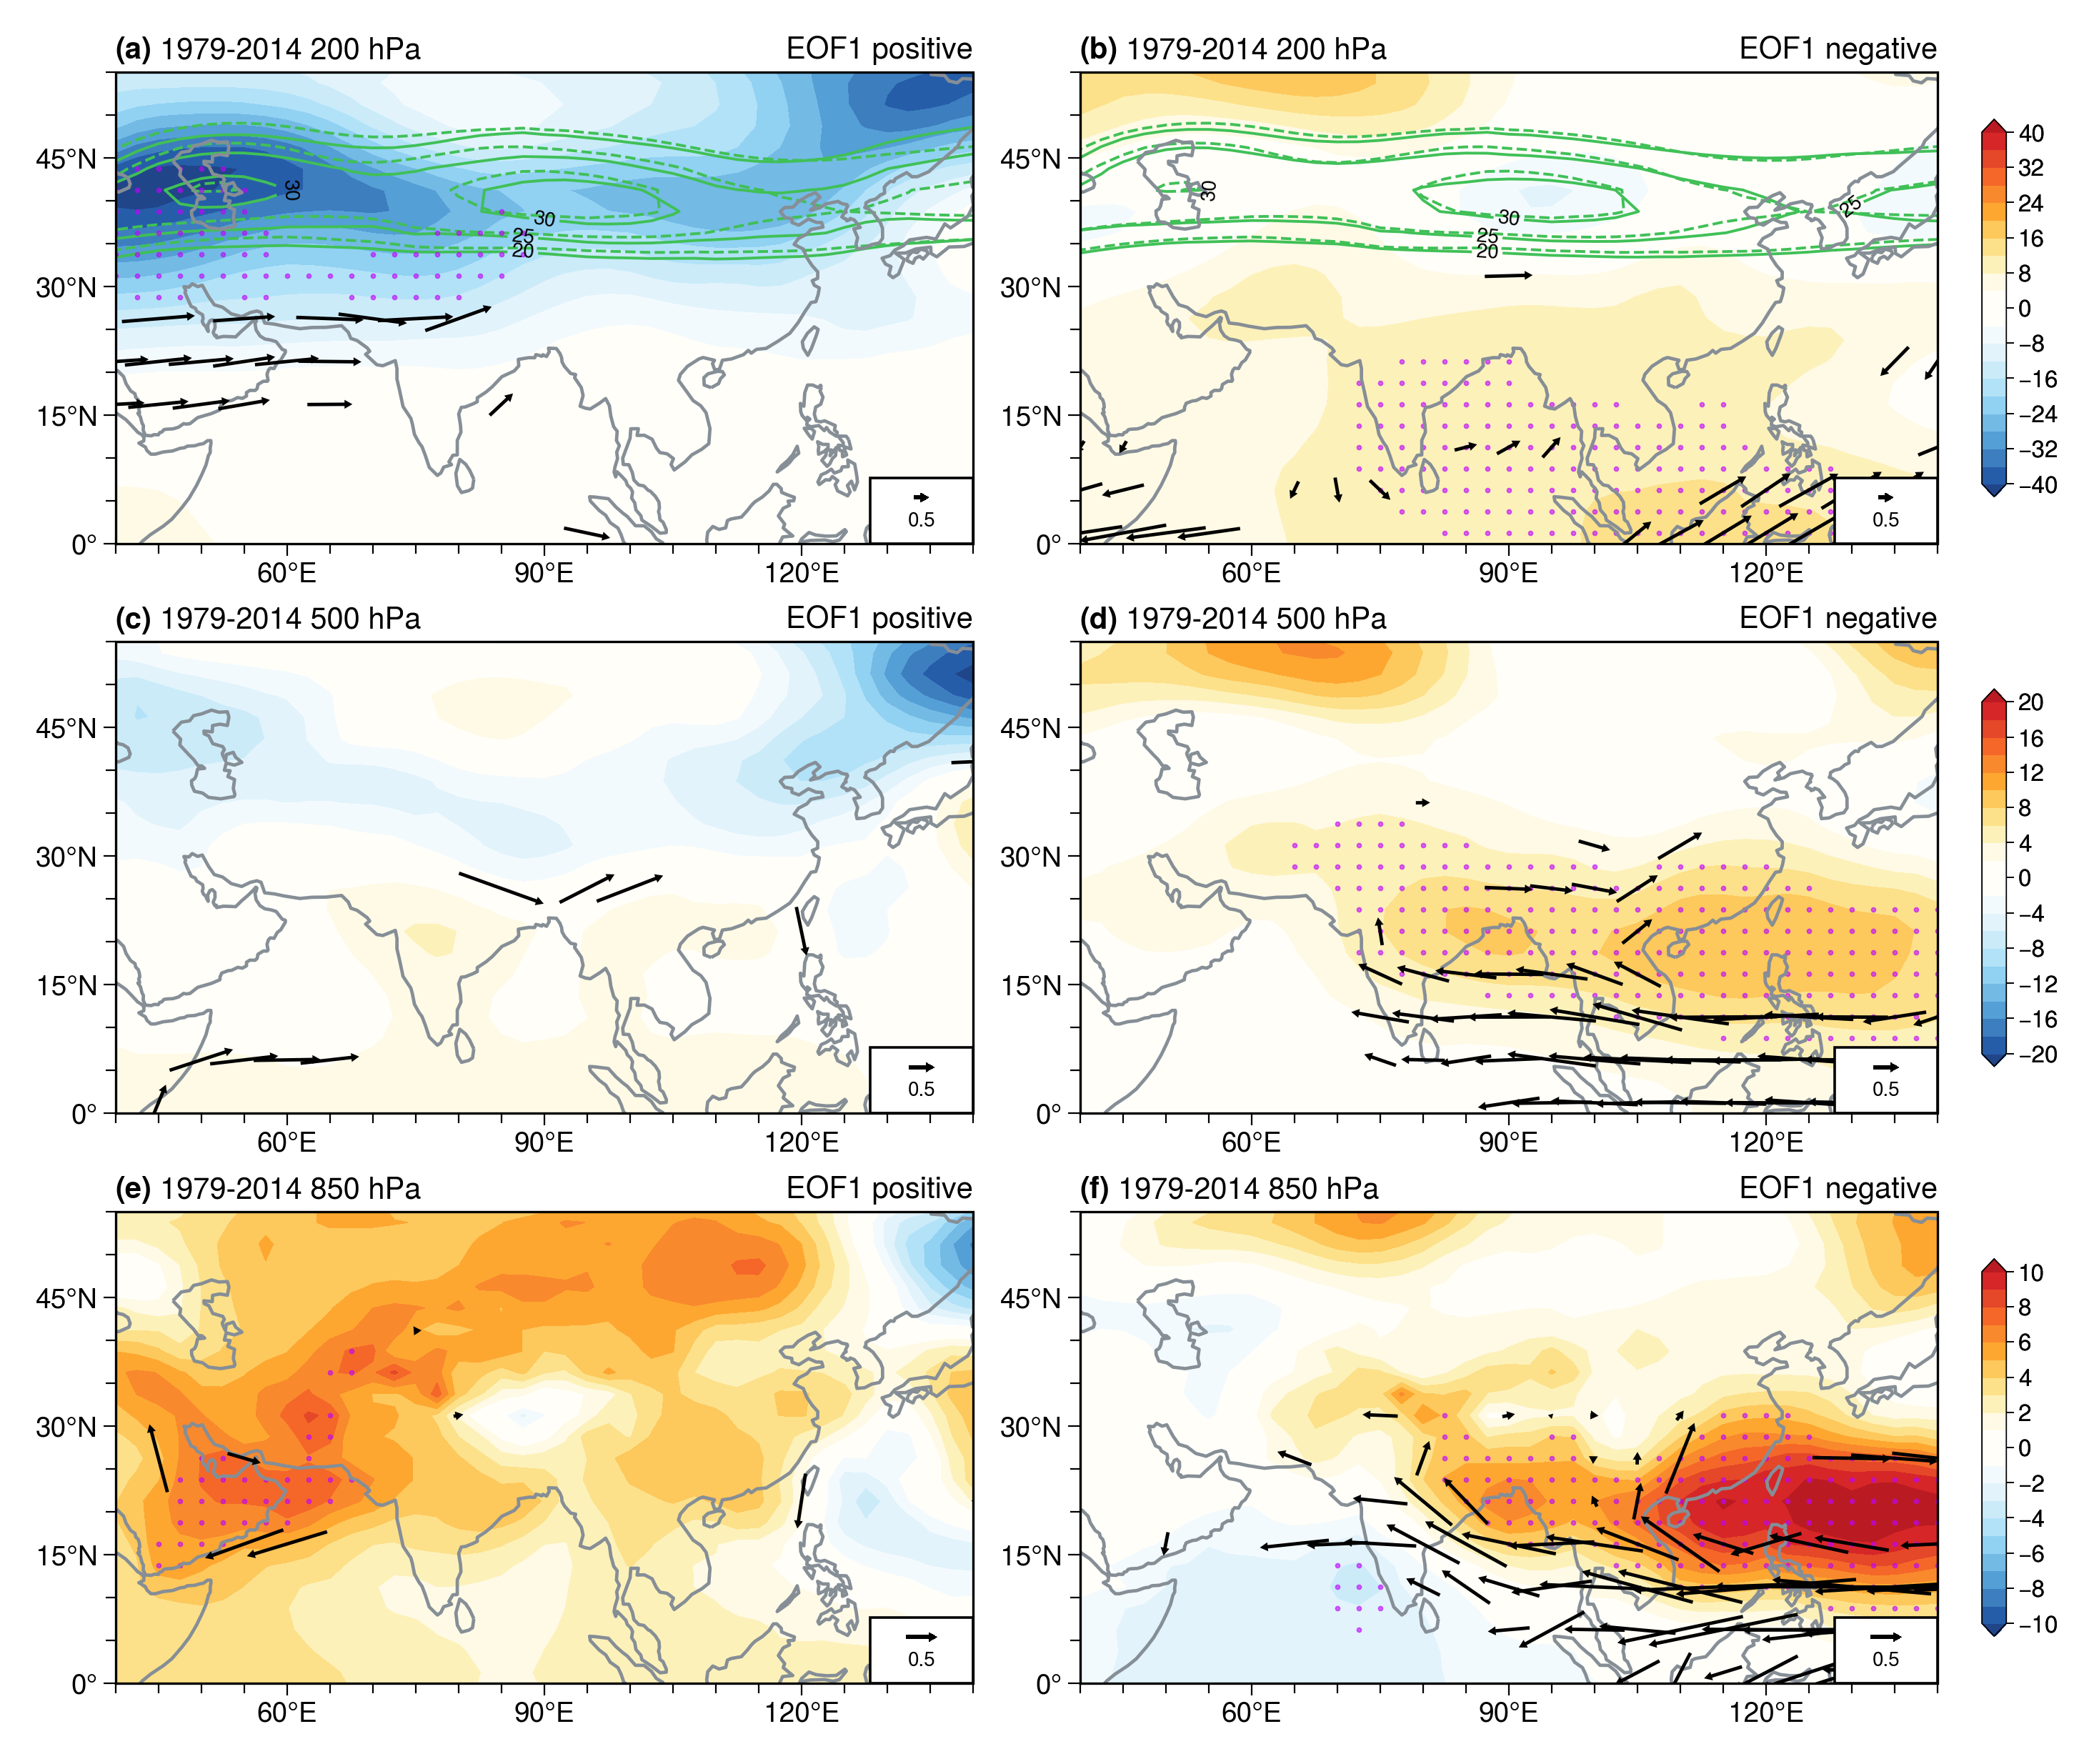

In [117]:
pplt.rc.reset()
pplt.rc.grid = False
startlevel=[-40, -20, -10]
spacinglevel=[4, 2, 1]
scalelevel=[0.30, 0.17, 0.14]

cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig_GPCP_ENSO_shift_cir = pplt.figure(span=False, share=False, refwidth=6.0, wspace=6.0, hspace=5.5, outerpad=2.0)
nrows = 3
ncols = 2
plot_array = np.reshape(range(1, nrows*ncols+1), (nrows, ncols))
# plot_array[-1,-1] = 0
axs = fig_GPCP_ENSO_shift_cir.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
# xticks = np.array([30, 60, 90, 120, 150, 180])  # 设置纬度刻度
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(0, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [40.0, 140.0, yticks[0], 55.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=14, lonminorspace=5, coastlinewidth=1.7, majorticklabelpad=3.0, majorticklen=6.0, minorticklen=5.0)
# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ======================================
for ax in axs:
    rect = Rectangle((1 - w, 0), w, h, transform=ax.transAxes, fc="white", ec="k", lw=1.3, zorder=1.1)
    ax.add_patch(rect)
for num_lev,lev in enumerate([200.0, 500.0, 850.0]):
        
  con = axs[num_lev, 0].contourf(
      hgt_pos_comp.sel(level=lev) - hgtERA5_ver_JJA.sel(level=lev).mean(dim="time", skipna=True),
      cmap="ColdHot",
      cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
      levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
      zorder=0.8,
      extend="both"
  )
  sepl.plt_sig(
      hgt_pos_comp.sel(level=lev), axs[num_lev, 0], n, np.where(hgt_pos_mask.sel(level=lev)[::n, ::n] > 0.0), "bright purple", 19.0,
  )

  if lev == 200.0:
        CS = axs[num_lev, 0].contour(
          u_pos_comp.sel(level=200.0),
          color="green6",
          levels=np.array([20.0, 25.0, 30.0]),
          zorder=0.8,
          lw=1.4
        )
        sepl.contour_label(axs[num_lev, 0], CS, inline_spacing=3, fontsize=10, colors="k")
        CS = axs[num_lev, 0].contour(
          uERA5_ver_JJA.sel(level=200.0).mean(dim="time",skipna=True),
          color="green6",
          levels=np.array([20.0, 25.0, 30.0]),
          zorder=0.8,
          lw=1.4,
          linestyle="--"
        )
  m = axs[num_lev, 0].quiver(
      (u_pos_comp - uERA5_ver_JJA.mean(dim="time", skipna=True)).where(wind_pos_mask > 0).sel(level=lev)[::ski, ::ski],
      (v_pos_comp - vERA5_ver_JJA.mean(dim="time", skipna=True)).where(wind_pos_mask > 0).sel(level=lev)[::ski, ::ski],
      zorder=1.1,
      headwidth=2.6,
      headlength=2.3,
      headaxislength=2.3,
      minlength=0.5,
      width=0.004,
      scale_units="xy",
      scale=scalelevel[num_lev],
      pivot="mid",
      color="black",
  )

  qk = axs[num_lev, 0].quiverkey(
      m, X=1 - w / 2, Y=0.7 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.10, fontproperties={"size": 10}, zorder=3.1,
  )
  axs[num_lev, 0].format(
      ltitle="1979-2014 {:.0f} hPa".format(lev), rtitle="EOF1 positive".format(i+1),
  )
  # ======================================
  con = axs[num_lev, 1].contourf(
      hgt_neg_comp.sel(level=lev) - hgtERA5_ver_JJA.sel(level=lev).mean(dim="time", skipna=True),
      cmap="ColdHot",
      cmap_kw={"left": 0.06, "right": 0.94, "cut": -0.1},
      levels=np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]),
      zorder=0.8,
      extend="both"
  )
  sepl.plt_sig(
      hgt_neg_comp.sel(level=lev), axs[num_lev, 1], n, np.where(hgt_neg_mask.sel(level=lev)[::n, ::n] > 0.0), "bright purple", 19.0,
  )
  if lev == 200.0:
        CS = axs[num_lev, 1].contour(
          u_neg_comp.sel(level=200.0),
          color="green6",
          levels=np.array([20.0, 25.0, 30.0]),
          zorder=0.8,
          lw=1.4
        )
        sepl.contour_label(axs[num_lev, 1], CS, inline_spacing=3, fontsize=10, colors="k")
        CS = axs[num_lev, 1].contour(
          uERA5_ver_JJA.sel(level=200.0).mean(dim="time",skipna=True),
          color="green6",
          levels=np.array([20.0, 25.0, 30.0]),
          zorder=0.8,
          lw=1.4,
          linestyle="--"
        )

  m = axs[num_lev, 1].quiver(
      (u_neg_comp - uERA5_ver_JJA.mean(dim="time", skipna=True)).where(wind_neg_mask > 0).sel(level=lev)[::ski, ::ski],
      (v_neg_comp - vERA5_ver_JJA.mean(dim="time", skipna=True)).where(wind_neg_mask > 0).sel(level=lev)[::ski, ::ski],
      zorder=1.1,
      headwidth=2.6,
      headlength=2.3,
      headaxislength=2.3,
      minlength=0.5,
      width=0.004,
      scale_units="xy",
      scale=scalelevel[num_lev],
      pivot="mid",
      color="black",
  )

  qk = axs[num_lev, 1].quiverkey(
      m, X=1 - w / 2, Y=0.7 * h, U=0.5, label="0.5", labelpos="S", labelsep=0.10, fontproperties={"size": 10}, zorder=3.1,
  )
  axs[num_lev, 1].format(
      ltitle="1979-2014 {:.0f} hPa".format(lev), rtitle="EOF1 negative".format(i+1),
  )
  cb = axs[num_lev, 1].colorbar(con, loc="r", width=0.17, length=0.8, label="", ticklabelsize=12, pad=2.5)
  cb.set_ticks(np.arange(startlevel[num_lev], -startlevel[num_lev]+spacinglevel[num_lev], spacinglevel[num_lev]*2))
# ======================================
axs.format(linewidth=1.2, titlepad=7.0)
fig_GPCP_ENSO_shift_cir.format(abc="(a)", abcloc="l", rc_kw={"grid": False, "reso":"lo", "figure.facecolor":"white", "font.large":15})
pplt.rc.reset()

In [118]:
India_N = 35.0
India_S = 5.0
India_W = 70.0
India_E = 85.0

NC_N = 40.0
NC_S = 32.5
NC_W = 105.0
NC_E = 120.0

/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/soft/anaconda3/envs/chenhj_test_cartopy/lib/python3.8/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/hom

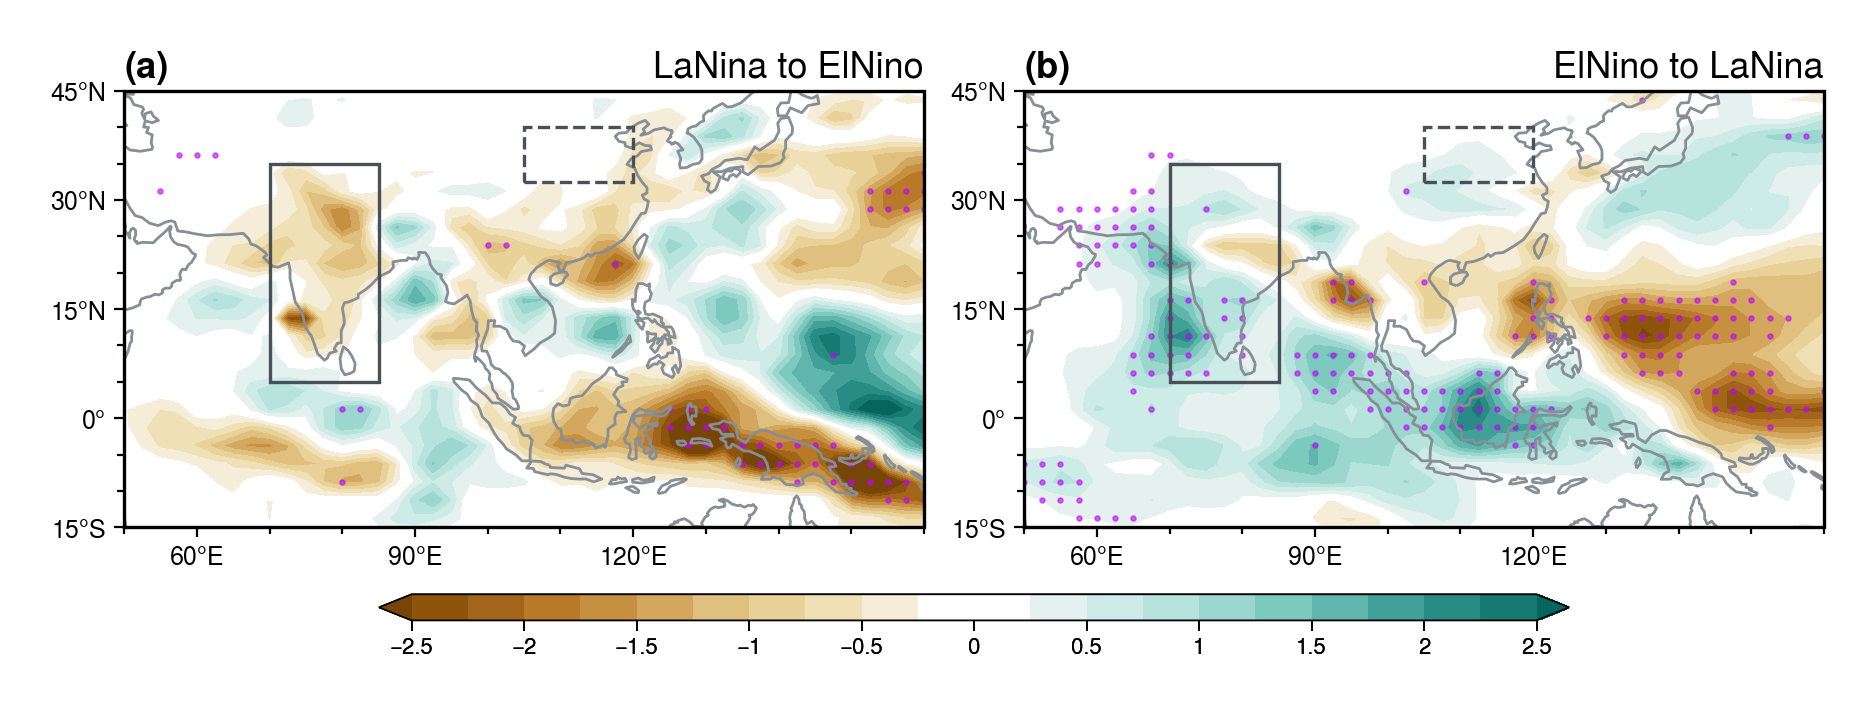

In [119]:
pplt.rc.reset()
pplt.rc.grid = False
# pplt.rc.reset()
cl = 0  # 设置地图投影的中心纬度
proj = pplt.PlateCarree(central_longitude=cl)

fig_GPCP_ENSO_shift_pre = pplt.figure(span=False, share=False, refwidth=4.0, wspace=4.0, hspace=4.5, outerpad=2.0)
nrows = 1
ncols = 2
plot_array = np.reshape(range(1, nrows*ncols+1), (nrows, ncols))
axs = fig_GPCP_ENSO_shift_pre.subplots(plot_array, proj=proj)

#   set the geo_ticks and map projection to the plots
xticks = np.array([60, 90, 120])  # 设置纬度刻度
yticks = np.arange(-15, 46, 15)  # 设置经度刻度
# 设置绘图的经纬度范围extents，其中前两个参数为经度的最小值和最大值，后两个数为纬度的最小值和最大值
# 当想要显示的经纬度范围不是正好等于刻度显示范围时，对extents进行相应的修改即可
extents = [50.0, 160.0, yticks[0], 45.0]
sepl.geo_ticks(axs, xticks, yticks, cl, extents, majorticklabelsize=font_size, coastlinewidth=1.0, majorticklabelpad=3.0, majorticklen=3.5, minorticklen=2.5)

# ===================================================
ski = 2
n = 1
w, h = 0.12, 0.14
# ===================================================
for ax in axs:
    # NC area
    x0 = NC_W
    y0 = NC_S
    width = NC_E-NC_W
    height = NC_N-NC_S
    sepl.patches(ax, x0 - cl, y0, width, height, proj, linewidth=1.2)
    # India
    x0 = India_W
    y0 = India_S
    width = India_E-India_W
    height = India_N-India_S
    sepl.patches(ax, x0 - cl, y0, width, height, proj, linestyle="-", linewidth=1.2)
# ===================================================
con = axs[0,0].contourf(
    pre_pos_comp-preGPCP_JJA.mean(dim="time", skipna=True),
    cmap=prep_colormap,
    cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-2.5,2.6,0.25),
    zorder=0.8,
    extend="both"
    )
sepl.plt_sig(
    pre_pos_comp-preGPCP_JJA.mean(dim="time", skipna=True), axs[0,0], n, np.where(pre_pos_mask[::n, ::n] > 0.0), "bright purple", 12.0,
)

axs[0,0].format(
    ltitle="", rtitle="LaNina to ElNino",
)
# ===================================================
con = axs[0,1].contourf(
    pre_neg_comp-preGPCP_JJA.mean(dim="time", skipna=True),
    cmap=prep_colormap,
    cmap_kw={"left": 0.06, "right": 0.94},
    levels=np.arange(-2.5,2.6,0.25),
    zorder=0.8,
    extend="both"
    )
sepl.plt_sig(
    pre_neg_comp-preGPCP_JJA.mean(dim="time", skipna=True), axs[0,1], n, np.where(pre_neg_mask[::n, ::n] > 0.0), "bright purple", 12.0,
)

axs[0,1].format(
    ltitle="", rtitle="ElNino to LaNina",
)
# ===================================================

cb = fig_GPCP_ENSO_shift_pre.colorbar(con, loc="b", width=0.13, length=0.7, label="", ticklabelsize=8)
# cb.set_ticks(np.arange(-
# 2.0,2.1, 0.4))
axs.format(linewidth=1.2)
fig_GPCP_ENSO_shift_pre.format(abc="(a)", abcloc="l", rc_kw={"grid": False, "reso": "lo", "figure.facecolor":"white", "font.large": 13})
pplt.rc.reset()